In [1]:
import mediapipe as mp
from mediapipe.tasks.python.vision import (
    GestureRecognizer,
    GestureRecognizerOptions,
    RunningMode,
    GestureRecognizerResult,
)
from mediapipe.tasks.python.vision.hand_landmarker import HandLandmark
from mediapipe.python.solutions import (
    drawing_utils as mp_drawing,
    drawing_styles as mp_drawing_styles,
    hands as mp_hands,
)
from mediapipe.framework.formats import landmark_pb2

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Path to task model to use
MODEL_PATH = "../models/gesture_recognizer.task"

In [3]:
# Create gesture recognizer options
base_options = mp.tasks.BaseOptions(model_asset_path=MODEL_PATH)
options = GestureRecognizerOptions(
    base_options,
    # Image mode
    running_mode=RunningMode.IMAGE,
    # Limit the allowed categories
    canned_gesture_classifier_options=mp.tasks.components.processors.ClassifierOptions(
        category_allowlist=["None", "Closed_Fist", "Open_Palm", "Victory"],
    ),
)

In [4]:
recognizer = GestureRecognizer.create_from_options(options)

In [5]:
# Adapted directly from code example
def draw_hand_landmarks(frame: np.ndarray, hand_landmarks: list[HandLandmark]):
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    mp_drawing.draw_landmarks(
        frame,
        hand_landmarks_proto,
        mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style(),
    )

In [6]:
def recognize_image(image_path: str):
    # Create MP image and recognize
    mp_image = mp.Image.create_from_file(image_path)
    result = recognizer.recognize(mp_image)

    # Numpy view for plotting
    mp_image = mp_image.numpy_view()

    # If hand landmarks detected, draw on top of image to be displayed
    if result.hand_landmarks:
        # Copy to draw over
        mp_image = mp_image.copy()
        draw_hand_landmarks(mp_image, result.hand_landmarks[0])

    # Two subplots
    # Left is image
    # Right is bar plot
    figs, axs = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[1, 2])

    # Bar plot labels
    gesture_labels = [
        "'None'",
        "Closed_Fist\n(Rock)",
        "Open_Palm\n(Paper)",
        "Victory\n(Scissors)",
    ]
    
    # If any gestures found, set up plots with it.
    # Otherwise default to "zero".
    if result.gestures:
        gestures = result.gestures[0]

        img_title = f"Prediction: {gestures[0].category_name} ({gestures[0].score:.2f})"

        gestures = {
            gesture.category_name: gesture.score for gesture in result.gestures[0]
        }
        scores = [
            gestures.get("None", 0),
            gestures.get("Closed_Fist", 0),
            gestures.get("Open_Palm", 0),
            gestures.get("Victory", 0),
        ]
    else:
        img_title = f"No prediction (no hand found?)"
        scores = [0 for _ in gesture_labels]

    axs[0].imshow(mp_image)
    axs[0].set_title(img_title, fontsize=16, color='black', fontdict={'verticalalignment':'center'}, pad=10)

    axs[1].bar(gesture_labels, scores)
    axs[1].set_ylim(0.0, 1.0)

    plt.show()

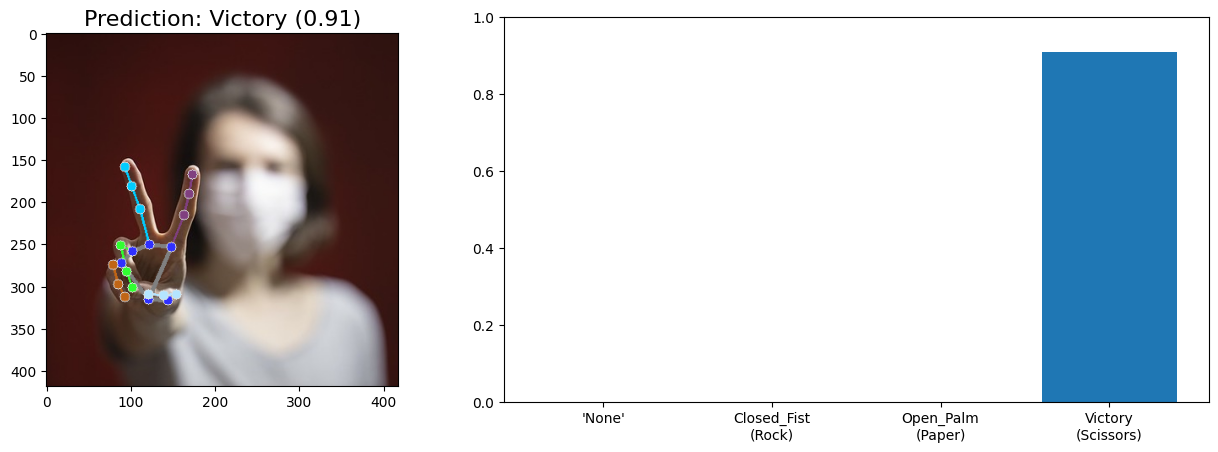

In [7]:
recognize_image("../img/victory.jpg")

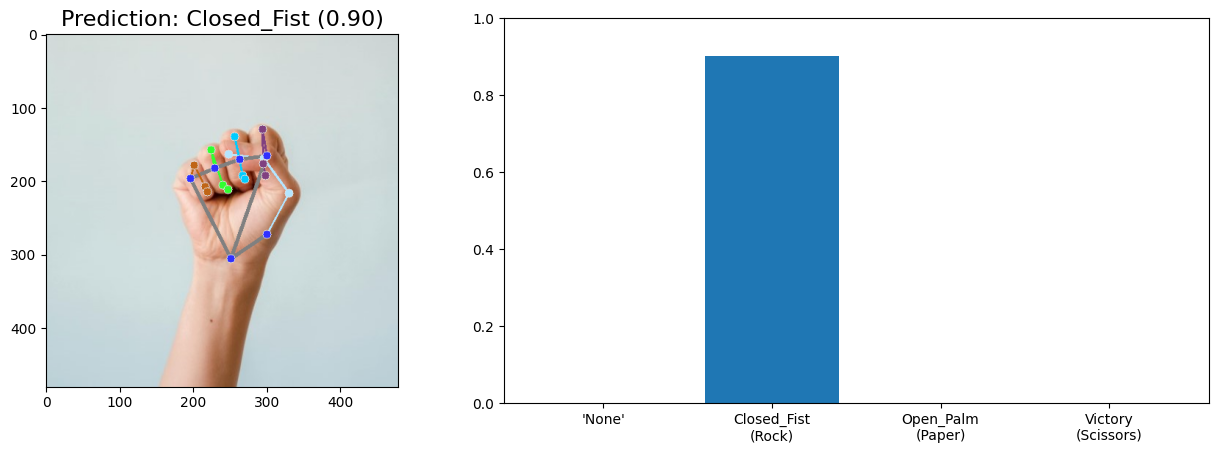

In [8]:
recognize_image("../img/closed_fist_ideal.jpg")

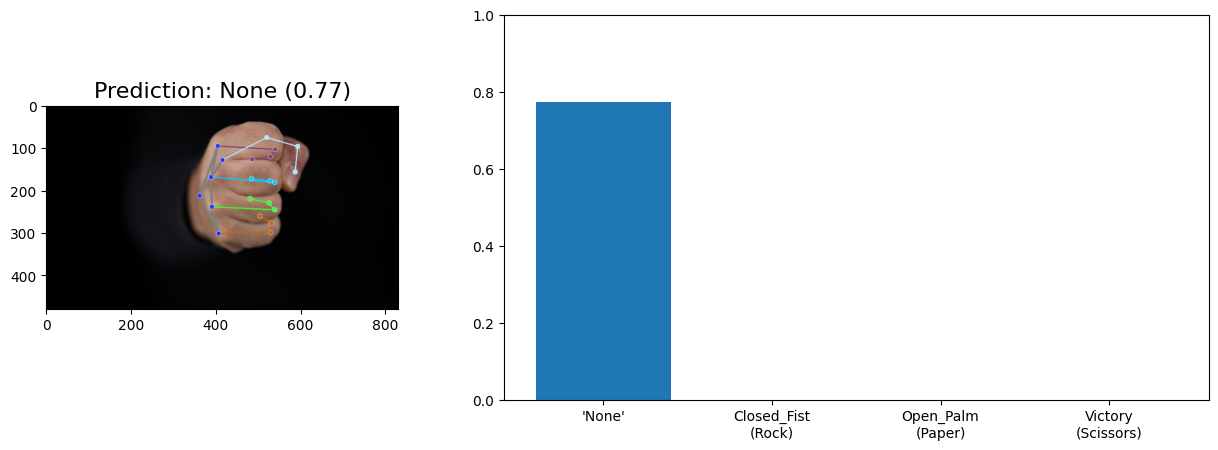

In [9]:
recognize_image("../img/rock.jpg")

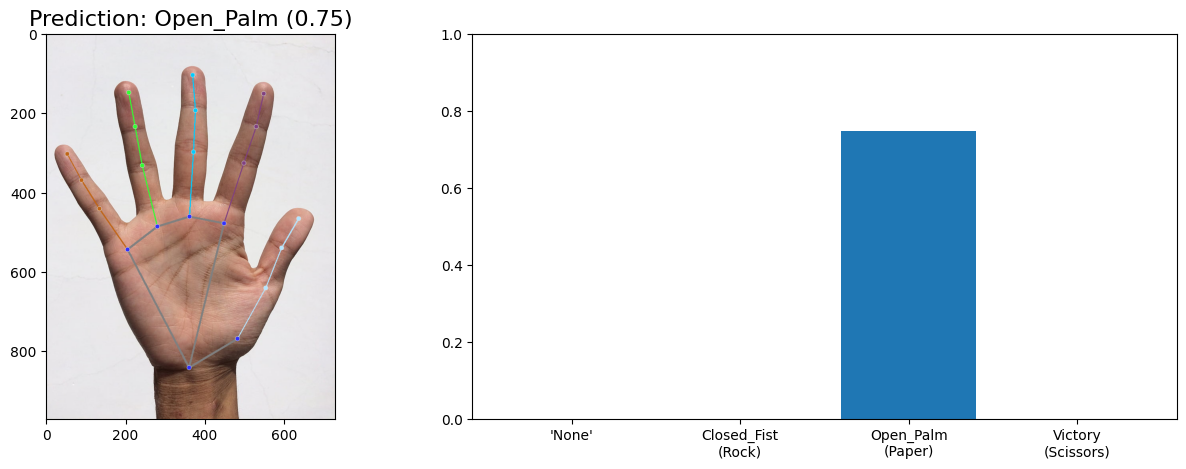

In [10]:
recognize_image("../img/open_palm_ideal.jpg")

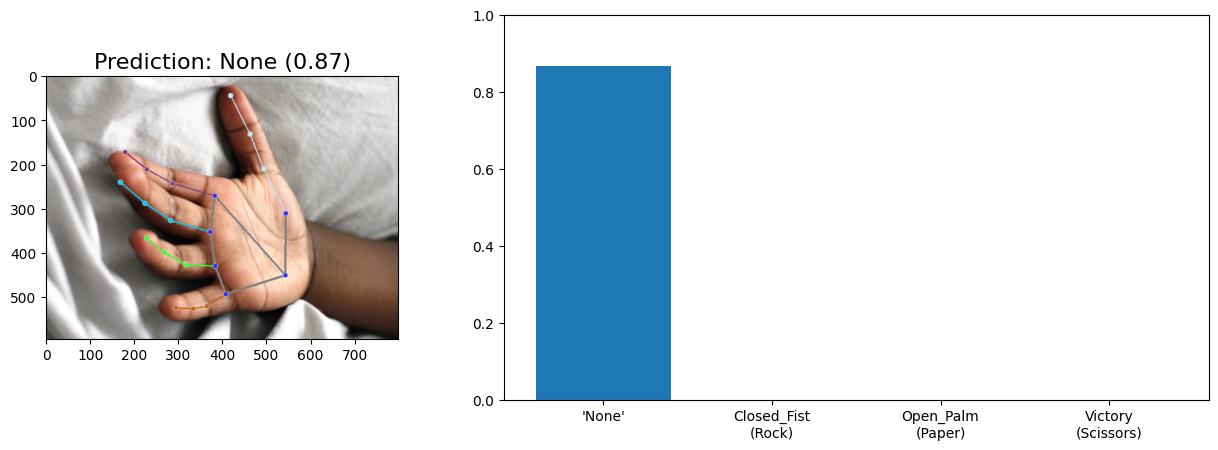

In [11]:
recognize_image("../img/paper.jpg")